# plot_experiment

> Given an experiment, provide all plots for examining one variable at a time.

In [ ]:
#| default_exp plot_experiment

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.all import *
from experiment_to_plot_framework.plot import *
import os

In [ ]:
#| export
from potentiostat_data_parser.chi import parse_chi_file
from potentiostat_data_parser.palmsens import parse_palmsens_file
import warnings # to warn when experiment contains both CHI and Palmsens files
import matplotlib._color_data as mcd
import numpy as np

We can motivate this library by generating plots for a simple experiment, various levels of IAA concentration. This is a CHI dataset.

In [ ]:
iaa_mnge_root = "../test_data/iaa_mnge"
os.listdir(iaa_mnge_root)

['IAA_7.8125uM_MNGE_GCE_2_250206.txt',
 'IAA_62.5uM_MNGE_GCE_2_250206.txt',
 'IAA_31.25uM_MNGE_GCE_2_250206.txt',
 'IAA_15.625uM_MNGE_GCE_2_250206.txt']

In [ ]:
fpath = os.path.join(iaa_mnge_root)

with open(os.path.join(fpath, "IAA_7.8125uM_MNGE_GCE_2_250206.txt")) as f:
    contents = f.read()

output_dict = parse_chi_file(contents)
output_dict["numeric_data"] = {k: v[:5] for k, v in output_dict["numeric_data"].items()} # truncate the numeric data just for better display

output_dict

{'memo': {'timestamp': '2025-02-06T17:35:06',
  'technique': 'Differential Pulse Voltammetry',
  'file': 'iaa_7.8125um_mnge_gce_2_250206.bin',
  'instrument_model': 'CHI1040C'},
 'parameters': {'Init E (V)': 0.2,
  'Final E (V)': 1.0,
  'Incr E (V)': 0.002,
  'Amplitude (V)': 0.025,
  'Pulse Width (sec)': 0.05,
  'Sample Width (sec)': 0.0167,
  'Pulse Period (sec)': 0.5,
  'Quiet Time (sec)': 2.0,
  'Sensitivity (A/V)': 1e-06},
 'numeric_data': {'Potential/V': array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
  'Current/A': array([-6.596e-07, -6.557e-07, -6.549e-07, -6.547e-07, -6.545e-07])}}

The objective is to create an interface where the user defines
1. the files that need to be parsed within a dataset
2. how we map each reading to an experimental condition

The system automatically figures out which parser to use, based on the file extension (CHI is .txt and Palmsens is .csv).
Then it
1. reads in the file data according to the specified files
2. maps each measurement to experimental condition according to the user map
3. calculates all plots required to cover one variable experimental plotting 

Architecturally, we can have the user define a map that takes in a file path and maps it to a tuple, assuming there's only one measurement within the file. This provides all files as well as the mapping to experimental conditions at the same time
**This means files with multiple measurements are not yet supported.**

In [ ]:
fpath_to_experimental_vars = {
    'IAA_7.8125uM_MNGE_GCE_2_250206.txt': 7.8125,
    'IAA_62.5uM_MNGE_GCE_2_250206.txt': 62.5,
    'IAA_31.25uM_MNGE_GCE_2_250206.txt': 31.25,
    'IAA_15.625uM_MNGE_GCE_2_250206.txt': 15.625,
}

Now we just build the class that takes this in

In [ ]:
#| export
# helper function to load fpath to experimental variables while validating
def _load_fpath_to_experimental_vars(fpath_to_experimental_vars):
        # if any values are not within a tuple, wrap them in a one element tuple
        fpath_mapping = {}

        proper_expt_vars_len = None
        for fpath, expt_vars in fpath_to_experimental_vars.items():
            if not isinstance(expt_vars, tuple):
                expt_vars = (expt_vars, ) # cast if necessary
                expt_vars_len = 1
            else:
                expt_vars_len = len(expt_vars)
            
            # check that expt vars len is consistent with all others
            if not proper_expt_vars_len:
                proper_expt_vars_len = expt_vars_len # set the proper len if it hasn't been set yet
            else:
                if proper_expt_vars_len != expt_vars_len:
                    raise ValueError(f"The experimental variables for fpath {fpath!r} ({expt_vars!r}) has length ({len(expt_vars)!r}) whereas other data has length ({proper_expt_vars_len!r})")
            
            fpath_mapping[fpath] = expt_vars

        return fpath_mapping

In [ ]:
class ExperimentPlotter:
    def __init__(
        self,
        fpath_to_experimental_vars: dict[str, any or tuple] # mapping from fpath to experimental variables (if there's only one), or a tuple of experimental variables
    ):
        # save experimental vars
        self.fpath_to_experimental_vars = _load_fpath_to_experimental_vars(fpath_to_experimental_vars)

# normal function
assert ExperimentPlotter(fpath_to_experimental_vars).fpath_to_experimental_vars == {'IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7.8125,),
 'IAA_62.5uM_MNGE_GCE_2_250206.txt': (62.5,),
 'IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 'IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}

# error when expt vars isn't a consistent shape
test_fail(lambda: ExperimentPlotter({"a.csv": 1, "b.csv": 2, "c.csv": (1, 2)}))

That covers user input. Now, we need to read in the file data. If it's a .txt file, we read and parse CHI, asserting that there's only one channel's-worth of information. IF it's a .csv file, we parse Palmsens, asserting that there's only one measurement in the file.

In [ ]:
#| export
def chi_read(fpath):
    with open(fpath, "r", encoding="utf-8") as f:
        return f.read()

def chi_postprocessor(parser_output):
    data = parser_output["numeric_data"]
    if "Current/A" not in data:
        raise ValueError(f"Current/A not detected as a data column. Instead, found {list(data.keys())!r}. Note that multichannel data is not supported yet.")

    return { "potential": data["Potential/V"], "current": data["Current/A"] }

def palmsens_read(fpath):
    with open(fpath, "r", encoding="utf-16") as f:
        return f.read()

def palmsens_postprocessor(parser_output):
    if len(parser_output) != 1:
        raise ValueError(f"We currently only support one measurement per file, but this file contains {len(parser_output)!r} measurements.")
    data = parser_output[0]
    return { "potential": data["potential"], "current": data["current"] }

fuse_processing = lambda read, parse, postprocess: (lambda fpath: postprocess(parse(read(fpath))))

def process_file(
    fpath # Potentiostat output file (.csv for Palmsens or .txt for CHI)
) -> dict[str: np.ndarray]: # dictionary with `"potential` (potential in V) and `"current"` (current in A)
    if fpath.endswith(".txt"):
        processor = fuse_processing(chi_read, parse_chi_file, chi_postprocessor)
    elif fpath.endswith(".csv"):
        processor = fuse_processing(palmsens_read, parse_palmsens_file, palmsens_postprocessor)

    return processor(fpath)

In [ ]:
# testing on CHI
fpath = 'IAA_62.5uM_MNGE_GCE_2_250206.txt'
chi_output = {k: v[:5] for k, v in process_file(os.path.join(iaa_mnge_root, fpath)).items()}
test(chi_output, {'potential': np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]), 'current': np.array([-6.733e-07, -6.715e-07, -6.721e-07, -6.728e-07, -6.733e-07])}, all_equal)

# testing on Palmsens
fpath = "../test_data/iaa_m9_pH/250211_Blank_M9_pH5_GCE_DPV.csv"
ps_output = {k: v[:5] for k, v in process_file(fpath).items()}
test(ps_output, {'potential': np.array([0.        , 0.01020757, 0.02041514, 0.03062271, 0.04083028]), 'current': np.array([2.1246306e-08, 2.0322310e-08, 1.9476714e-08, 1.9017516e-08,
       1.8608716e-08])}, all_equal)

So we've got the code that reads in the data. We've got the map. Now we need the code that generates the files we need according to experimental parameters

For instance, if we had concentrations \[0, 5, 10, 15], then it should be a single plot with all of them in order \[(0, 5, 10, 15)]. If we had two variables, we might have experimental value tuples of \[(0, 5), (5, 5), (10, 5), (0, 6), (5, 6), (10, 6), (0, 7), (5, 7), (10, 7)] where each tuple represents (concentration, pH). In other words, it'd be a grid of concentrations of \[0, 5, 10] and pHs of \[5, 6, 7]. Then it'd would be 
```python
[
    [(0, 5), (5, 5), (10, 5)], # change conc, pH=5
    [(0, 6), (5, 6), (10, 6)], # change conc, pH=6
    [(0, 7), (5, 7), (10, 7)], # change conc, pH=7
    [(0, 5), (0, 6), (0, 7)], # conc=0, change pH
    [(5, 5), (5, 6), (5, 7)], # conc=5, change pH
    [(10, 5), (10, 6), (10, 7)] # conc=10, change pH
]
```

In other words, for each unique variable value within a dimension, keep that dimension constant and then change the other one. To keep it simple, we're only supporting a max of two experimental variables. Three is uncommon and requires a more generalized algorithm.

So, we're making an algorithm that takes in all the tuples generated by mapping. if tuples are only len 1, then just sort them and that's the job done. If tuples are len 2, then go through the first dimension's unique values and group everything that way. Then do the analogous operation on the other dimension.

In [ ]:
single_tuple_list = [(3,), (8,), (7,), (1,), (5,)]
experimental_tuples = single_tuple_list

# if it's len 1, then just sort by that single dimension. and there's only one plot
plot_combos = [sorted(set(single_tuple_list), key=lambda x: x[0])] # the set part is to remove duplicates
plot_combos

[[(1,), (3,), (5,), (7,), (8,)]]

In [ ]:
double_tuple_list = [(0, 5), (5, 5), (10, 5), (10, 7), (5, 7), (0, 7), (0, 6), (10, 6), (5, 6)]
experimental_tuples = np.array(double_tuple_list)

# zero-th column is the one we're sorting on. this is just an example to get started. the example covers the first column only
unique_col, other_col = 0, 1
unique_var, var_indices = np.unique(experimental_tuples[:, 0], axis=0, return_inverse=True) # unique values for the first column

current_plot_list = experimental_tuples[var_indices == 0].tolist()
current_plot_list

[[0, 5], [0, 7], [0, 6]]

In [ ]:
# now sort it and make it tuples
sorted([tuple(x) for x in current_plot_list], key=lambda x: x[other_col]) # this is the output we want

[(0, 5), (0, 6), (0, 7)]

In [ ]:
plot_list = []

for i in range(len(unique_var)):
    current_plot_list = experimental_tuples[var_indices == i].tolist()
    current_plot_list = sorted([tuple(x) for x in current_plot_list], key=lambda x: x[other_col])
    plot_list.append(current_plot_list)

plot_list

[[(0, 5), (0, 6), (0, 7)],
 [(5, 5), (5, 6), (5, 7)],
 [(10, 5), (10, 6), (10, 7)]]

we've built up all plots in terms of their experimental variables for the first column (concentration), now we just switch the values for unique_col and other col to get the plots for the second column

In [ ]:
unique_col, other_col = 1, 0
unique_var, var_indices = np.unique(experimental_tuples[:, unique_col], axis=0, return_inverse=True) # unique values for unique_col

plot_list = []

for i in range(len(unique_var)):
    current_plot_list = experimental_tuples[var_indices == i].tolist()
    current_plot_list = sorted([tuple(x) for x in current_plot_list], key=lambda x: x[other_col])
    plot_list.append(current_plot_list)

plot_list

[[(0, 5), (5, 5), (10, 5)],
 [(0, 6), (5, 6), (10, 6)],
 [(0, 7), (5, 7), (10, 7)]]

and that's correct for the second column. which means we can just put everything together and it should work.

In [ ]:
#| export
def generate_plot_vars_len_two_helper(
    var_tuples: list[tuple], # input tuples 
    unique_col: int, # the index of the column to keep constant. either 0 or 1
):
    if unique_col not in [0, 1]: raise ValueError(f"Expected unique_col to be either 0 or 1, but received {unique_col!r}")
    other_col = 0 if unique_col == 1 else 1

    if isinstance(var_tuples, list):
        var_tuples = np.array(var_tuples)
    
    unique_var, var_indices = np.unique(var_tuples[:, unique_col], axis=0, return_inverse=True) # unique values for unique_col
    plot_list = []

    # generate the one variable change plot specs in terms of experimental varA
    for i in range(len(unique_var)):
        current_plot_list = var_tuples[var_indices == i].tolist()
        current_plot_list = sorted([tuple(x) for x in current_plot_list], key=lambda x: x[other_col])

        if len(current_plot_list) > 1: # don't bother adding plots that are a single measurement
            plot_list.append(current_plot_list)

    return plot_list

def generate_plot_vars(
    var_tuples: list[tuple] # list of experimental values tuples. assumed to all have the same length
):
    tuple_len = len(var_tuples[0])
    if tuple_len == 0:
        return []
    if tuple_len == 1: # single var case
        return [sorted(set(var_tuples), key=lambda x: x[0])]
    elif tuple_len == 2: # double var case
        first_column_list = generate_plot_vars_len_two_helper(var_tuples, 0)
        second_column_list = generate_plot_vars_len_two_helper(var_tuples, 1)
        return first_column_list + second_column_list
    else:
        raise ValueError(f"Expected tuple length of either 1 or 2, but received tuple length {tuple_len!r}. Tuple length greater than 2 is not supported.")

In [ ]:
# single variable case
assert generate_plot_vars([(3,), (8,), (7,), (1,), (5,)]) == [[(1,), (3,), (5,), (7,), (8,)]]

# another similar case, floats
assert generate_plot_vars([(1.1,), (1.5,), (3.1,), (0.2,), (1.7,)]) == [[(0.2,), (1.1,), (1.5,), (1.7,), (3.1,)]]

# with a duplicate (expected behavior is to deduplicate)
assert generate_plot_vars([(3,), (3,), (5,)]) == [[(3,), (5,)]]

# double variable case
assert generate_plot_vars([(0, 5), (5, 5), (10, 5), (10, 7), (5, 7), (0, 7), (0, 6), (10, 6), (5, 6)]) == [[(0, 5), (0, 6), (0, 7)],
 [(5, 5), (5, 6), (5, 7)],
 [(10, 5), (10, 6), (10, 7)],
 [(0, 5), (5, 5), (10, 5)],
 [(0, 6), (5, 6), (10, 6)],
 [(0, 7), (5, 7), (10, 7)]]

# different case: conc=0 has an additional pH=8, pH=7 is missing its conc=5. in other words, removed (5, 7) and added (0, 8)
assert generate_plot_vars([(0, 5), (5, 5), (10, 5), (10, 7), (0, 7), (0, 6), (10, 6), (5, 6), (0, 8)]) == [[(0, 5), (0, 6), (0, 7), (0, 8)],
 [(5, 5), (5, 6)],
 [(10, 5), (10, 6), (10, 7)],
 [(0, 5), (5, 5), (10, 5)],
 [(0, 6), (5, 6), (10, 6)],
 [(0, 7), (10, 7)]]

fantastic. now that we've generated the plots according to vars, we just need to map vars back to files.

In [ ]:
fpath_to_vars = {'IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7.8125,),
 'IAA_62.5uM_MNGE_GCE_2_250206.txt': (62.5,),
 'IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 'IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}

# because one var can have multiple fpaths, reversal is a tad more complicated than reversing keys and values
unique_vars, vars_inverse = np.unique(list(fpath_to_vars.values()), axis=0, return_inverse=True)
unique_vars, vars_inverse

(array([[ 7.8125],
        [15.625 ],
        [31.25  ],
        [62.5   ]]),
 array([0, 3, 2, 1]))

In [ ]:
fpaths = np.array(list(fpath_to_vars.keys()))
{tuple(var): fpaths[vars_inverse == i].tolist() for i, var in enumerate(unique_vars.tolist())}

{(7.8125,): ['IAA_7.8125uM_MNGE_GCE_2_250206.txt'],
 (15.625,): ['IAA_15.625uM_MNGE_GCE_2_250206.txt'],
 (31.25,): ['IAA_31.25uM_MNGE_GCE_2_250206.txt'],
 (62.5,): ['IAA_62.5uM_MNGE_GCE_2_250206.txt']}

In [ ]:
#| export
def inverse_fpath_to_vars(fpath_to_vars: dict[str, tuple or any]):
    unique_vars, vars_inverse = np.unique(list(fpath_to_vars.values()), axis=0, return_inverse=True) # find unique values of vars, get inverse so we can reverse the relationship
    fpaths = np.array(list(fpath_to_vars.keys())) # cast so we can slice numpy arrays
    return {tuple(var): fpaths[vars_inverse == i].tolist() for i, var in enumerate(unique_vars.tolist())}

In [ ]:
assert inverse_fpath_to_vars({'IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7.8125,),
 'IAA_62.5uM_MNGE_GCE_2_250206.txt': (62.5,),
 'IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 'IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}) == {(7.8125,): ['IAA_7.8125uM_MNGE_GCE_2_250206.txt'],
 (15.625,): ['IAA_15.625uM_MNGE_GCE_2_250206.txt'],
 (31.25,): ['IAA_31.25uM_MNGE_GCE_2_250206.txt'],
 (62.5,): ['IAA_62.5uM_MNGE_GCE_2_250206.txt']}

assert inverse_fpath_to_vars({"5uM.txt": (5,), "5uM (1).txt": (5,), "10uM": (10,)}) == {(5,): ['5uM.txt', '5uM (1).txt'], (10,): ['10uM']}

And finally, we need to work out some specifics on plotting (coloring when there are multiple lines representing the same vars)

In [ ]:
dev_fpaths_to_vars = {'IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7,), # labeled 7
 'IAA_62.5uM_MNGE_GCE_2_250206.txt': (7,), # also labeled 7, just to test when multiple fpaths map to a single var
 'IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 'IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}
dev_fpaths_to_vars = {os.path.join(iaa_mnge_root, k): v for k, v in dev_fpaths_to_vars.items()}

vars_to_fpaths = inverse_fpath_to_vars(dev_fpaths_to_vars)
vars_to_fpaths

{(7.0,): ['../test_data/iaa_mnge/IAA_7.8125uM_MNGE_GCE_2_250206.txt',
  '../test_data/iaa_mnge/IAA_62.5uM_MNGE_GCE_2_250206.txt'],
 (15.625,): ['../test_data/iaa_mnge/IAA_15.625uM_MNGE_GCE_2_250206.txt'],
 (31.25,): ['../test_data/iaa_mnge/IAA_31.25uM_MNGE_GCE_2_250206.txt']}

In [ ]:
# now we generate the plots we need to make
list_of_plot_vars = list(dev_fpaths_to_vars.values())
to_plot_list = generate_plot_vars(list_of_plot_vars)
to_plot_list

[[(7,), (15.625,), (31.25,)]]

and now we need a new function that takes in a plot specified by vars (that's an element of `to_plot_list`) as well as vars_to_fpaths and generates the plot

In [ ]:
# let's do a single element for now
to_plot = to_plot_list[0]
current_var = to_plot[0]

fpaths_to_plot = vars_to_fpaths[current_var]
fpaths_to_plot

['../test_data/iaa_mnge/IAA_7.8125uM_MNGE_GCE_2_250206.txt',
 '../test_data/iaa_mnge/IAA_62.5uM_MNGE_GCE_2_250206.txt']

In [ ]:
# time to transform them into plot specs
# first, so colors make sense, we actually need to assign colors to all tuples that will be plotted
to_plot # map these to colors

[(7,), (15.625,), (31.25,)]

In [ ]:
colors = list(mcd.TABLEAU_COLORS) # these are the colors for the traces
colors

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [ ]:
#| export
def assign_colors(elements):
    colors = list(mcd.TABLEAU_COLORS)
    return {tup: colors[i % len(colors)] for i, tup in enumerate(elements)}

In [ ]:
# normal case
assert assign_colors(to_plot) == {(7,): 'tab:blue', (15.625,): 'tab:orange', (31.25,): 'tab:green'}

# more elements than colors should result in cycling
assert assign_colors(list(range(20))) == {0: 'tab:blue',
 1: 'tab:orange',
 2: 'tab:green',
 3: 'tab:red',
 4: 'tab:purple',
 5: 'tab:brown',
 6: 'tab:pink',
 7: 'tab:gray',
 8: 'tab:olive',
 9: 'tab:cyan',
 10: 'tab:blue',
 11: 'tab:orange',
 12: 'tab:green',
 13: 'tab:red',
 14: 'tab:purple',
 15: 'tab:brown',
 16: 'tab:pink',
 17: 'tab:gray',
 18: 'tab:olive',
 19: 'tab:cyan'}

now getting back on track

In [ ]:
# load fpaths to vars
dev_fpaths_to_vars = {'IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7,), # labeled 7
 'IAA_62.5uM_MNGE_GCE_2_250206.txt': (7,), # also labeled 7, just to test when multiple fpaths map to a single var
 'IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 'IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}
dev_fpaths_to_vars = {os.path.join(iaa_mnge_root, k): v for k, v in dev_fpaths_to_vars.items()}

fpaths_to_data = {fpath: process_file(fpath) for fpath in dev_fpaths_to_vars} # read the data

vars_to_fpaths = inverse_fpath_to_vars(dev_fpaths_to_vars) # generate inverse


list_of_plot_vars = list(dev_fpaths_to_vars.values())
to_plot_list = generate_plot_vars(list_of_plot_vars)

to_plot = to_plot_list[0]
colors = assign_colors(to_plot) # {(7,): 'tab:blue', (15.625,): 'tab:orange', (31.25,): 'tab:green'}

current_var = to_plot[0]
fpaths_to_plot = vars_to_fpaths[current_var] # ['../test_data/iaa_mnge/IAA_7.8125uM_MNGE_GCE_2_250206.txt', '../test_data/iaa_mnge/IAA_62.5uM_MNGE_GCE_2_250206.txt']
fpath_to_plot = fpaths_to_plot[0] # just the first one

# for a trace (a single line on the graph), i need the potential and current data
current_data_dict = fpaths_to_data[fpath_to_plot]
single_trace = [(current_data_dict["potential"], current_data_dict["current"]), {"color": colors[current_var], "label": f"{current_var[0]} uM"}]

[[arr[:5] for arr in single_trace[0]], single_trace[1]] # show a subset of the data

[[array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
  array([-6.596e-07, -6.557e-07, -6.549e-07, -6.547e-07, -6.545e-07])],
 {'color': 'tab:blue', 'label': '7 uM'}]

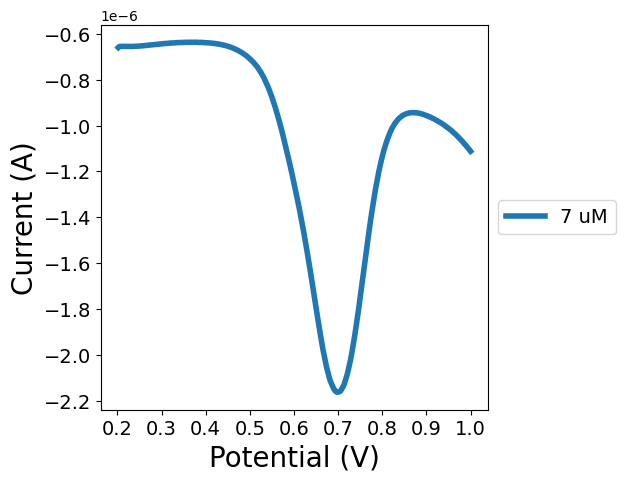

In [ ]:
mpl_wrapper([single_trace], xlabel="Potential (V)", ylabel="Current (A)")

and then, in general,

In [ ]:
# load fpaths to vars
dev_fpaths_to_vars = {'IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7,), # labeled 7
 'IAA_62.5uM_MNGE_GCE_2_250206.txt': (7,), # also labeled 7, just to test when multiple fpaths map to a single var
 'IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 'IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}
dev_fpaths_to_vars = {os.path.join(iaa_mnge_root, k): v for k, v in dev_fpaths_to_vars.items()}

fpaths_to_data = {fpath: process_file(fpath) for fpath in dev_fpaths_to_vars} # read the data

vars_to_fpaths = inverse_fpath_to_vars(dev_fpaths_to_vars) # generate inverse


list_of_plot_vars = list(dev_fpaths_to_vars.values())
to_plot_list = generate_plot_vars(list_of_plot_vars)

all_plot_specs = []

for to_plot in to_plot_list: # to_plot is something like [(7,), (15.625,), (31.25,)], specifying the vars that need to be plotted
    current_plot_spec = []
    colors = assign_colors(to_plot) # colors for an individual plot

    for current_var in to_plot: # current_var is something like (7,), representing the unique var that's being plotted 
        fpaths_to_plot = vars_to_fpaths[current_var] # all fpaths with that var combination, e.g. ['../test_data/iaa_mnge/IAA_7.8125uM_MNGE_GCE_2_250206.txt', '../test_data/iaa_mnge/IAA_62.5uM_MNGE_GCE_2_250206.txt']

        for fpath_to_plot_i, fpath_to_plot in enumerate(fpaths_to_plot):
            current_data_dict = fpaths_to_data[fpath_to_plot] # collect the data
            kwargs = {"color": colors[current_var]}

            if fpath_to_plot_i == 0: # only for the first one do we label, to avoid redundancy in the legend
                kwargs |= {"label": f"{current_var[0]} uM"} # NOTE that this is custom code! we want the user to provide a labeling scheme
                
            single_trace = [(current_data_dict["potential"], current_data_dict["current"]), kwargs]
            current_plot_spec.append(single_trace)
    
    all_plot_specs.append(current_plot_spec)

[[[arr[:5] for arr in trace[0]], trace[1]] for trace in all_plot_specs[0]]

[[[array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
   array([-6.596e-07, -6.557e-07, -6.549e-07, -6.547e-07, -6.545e-07])],
  {'color': 'tab:blue', 'label': '7 uM'}],
 [[array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
   array([-6.733e-07, -6.715e-07, -6.721e-07, -6.728e-07, -6.733e-07])],
  {'color': 'tab:blue'}],
 [[array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
   array([-6.862e-07, -6.799e-07, -6.774e-07, -6.759e-07, -6.741e-07])],
  {'color': 'tab:orange', 'label': '15.625 uM'}],
 [[array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
   array([-7.070e-07, -7.018e-07, -6.999e-07, -6.986e-07, -6.975e-07])],
  {'color': 'tab:green', 'label': '31.25 uM'}]]

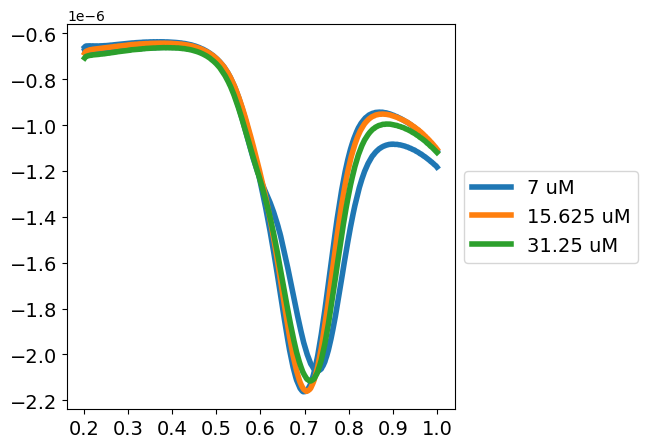

In [ ]:
mpl_wrapper(all_plot_specs[0])

Putting everying back into ExperimentPlotter,

In [ ]:
#| export
from typing import Callable

class ExperimentPlotter:
    def __init__(
        self,
        fpath_to_experimental_vars: dict[str, any or tuple], # mapping from fpath to experimental variables (if there's only one), or a tuple of experimental variables
        label_fn: Callable[[tuple], str] or None=None # function maps an experimental var tuple to the label that will be displayed in a plot
    ):
        self.fpath_to_experimental_vars = _load_fpath_to_experimental_vars(fpath_to_experimental_vars) # save experimental vars
        self.fpaths_to_data = {fpath: process_file(fpath) for fpath in self.fpath_to_experimental_vars} # grab the data
        self.vars_to_fpaths = inverse_fpath_to_vars(self.fpath_to_experimental_vars) # generate inverse of fpath_to_experimental_vars

        if not label_fn:
            label_fn = lambda x: str(x)
        self.label_fn = label_fn
        
        # generate plots in terms of vars
        list_of_plot_vars = list(self.fpath_to_experimental_vars.values())
        to_plot_list = generate_plot_vars(list_of_plot_vars)
        all_plot_specs = []
        
        for to_plot in to_plot_list: # to_plot is something like [(7,), (15.625,), (31.25,)], specifying the vars that need to be plotted
            current_plot_spec = []
            colors = assign_colors(to_plot) # colors for an individual plot
        
            for current_var in to_plot: # current_var is something like (7,), representing the unique var that's being plotted 
                fpaths_to_plot = self.vars_to_fpaths[current_var] # all fpaths with that var combination, e.g. ['../test_data/iaa_mnge/IAA_7.8125uM_MNGE_GCE_2_250206.txt', '../test_data/iaa_mnge/IAA_62.5uM_MNGE_GCE_2_250206.txt']
        
                for fpath_to_plot_i, fpath_to_plot in enumerate(fpaths_to_plot):
                    current_data_dict = self.fpaths_to_data[fpath_to_plot] # collect the data
                    kwargs = {"color": colors[current_var]}
        
                    if fpath_to_plot_i == 0: # only for the first one do we label, to avoid redundancy in the legend
                        kwargs |= {"label": label_fn(current_var)}
                        
                    single_trace = [(current_data_dict["potential"], current_data_dict["current"]), kwargs]
                    current_plot_spec.append(single_trace)
            
            all_plot_specs.append(current_plot_spec)
        self.plot_specs = all_plot_specs

In [ ]:
# tests, copied from the first time

# normal operation
fpath_to_experimental_vars = {
    'IAA_7.8125uM_MNGE_GCE_2_250206.txt': 7.8125,
    'IAA_62.5uM_MNGE_GCE_2_250206.txt': 62.5,
    'IAA_31.25uM_MNGE_GCE_2_250206.txt': 31.25,
    'IAA_15.625uM_MNGE_GCE_2_250206.txt': 15.625,
}
fpath_to_experimental_vars = {os.path.join(iaa_mnge_root, k): v for k, v in fpath_to_experimental_vars.items()}

assert ExperimentPlotter(fpath_to_experimental_vars).fpath_to_experimental_vars == {'../test_data/iaa_mnge/IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7.8125,),
 '../test_data/iaa_mnge/IAA_62.5uM_MNGE_GCE_2_250206.txt': (62.5,),
 '../test_data/iaa_mnge/IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 '../test_data/iaa_mnge/IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}

# error when expt vars isn't a consistent shape
test_fail(lambda: ExperimentPlotter(fpath_to_experimental_vars | {"IAA_62.5uM_MNGE_GCE_2_250206.txt": (62.5, 2)}).fpath_to_experimental_vars)

# error with nonexistent files
test_fail(lambda: ExperimentPlotter({"a.csv": 1, "b.csv": 2, "c.csv": (1, 2)}))

In [ ]:
fpaths_to_vars = {'IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7,), # labeled 7
 'IAA_62.5uM_MNGE_GCE_2_250206.txt': (7,), # also labeled 7, just to test when multiple fpaths map to a single var
 'IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 'IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}
fpaths_to_vars = {os.path.join(iaa_mnge_root, k): v for k, v in fpaths_to_vars.items()}

plot_specs = ExperimentPlotter(fpaths_to_vars, lambda x: f"{x[0]} uM").plot_specs
test([[[[arr[:5] for arr in trace[0]], trace[1]] for trace in plot_spec] for plot_spec in plot_specs], [[[[np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
    np.array([-6.596e-07, -6.557e-07, -6.549e-07, -6.547e-07, -6.545e-07])],
   {'color': 'tab:blue', 'label': '7 uM'}],
  [[np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
    np.array([-6.733e-07, -6.715e-07, -6.721e-07, -6.728e-07, -6.733e-07])],
   {'color': 'tab:blue'}],
  [[np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
    np.array([-6.862e-07, -6.799e-07, -6.774e-07, -6.759e-07, -6.741e-07])],
   {'color': 'tab:orange', 'label': '15.625 uM'}],
  [[np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
    np.array([-7.070e-07, -7.018e-07, -6.999e-07, -6.986e-07, -6.975e-07])],
   {'color': 'tab:green', 'label': '31.25 uM'}]]], all_equal)
mpl_wrapper(plot_specs[0])

In [ ]:
fpaths_to_vars = {'IAA_7.8125uM_MNGE_GCE_2_250206.txt': (7.8125,), # correctly labeled
 'IAA_62.5uM_MNGE_GCE_2_250206.txt': (62.5,), # correctly labeled
 'IAA_31.25uM_MNGE_GCE_2_250206.txt': (31.25,),
 'IAA_15.625uM_MNGE_GCE_2_250206.txt': (15.625,)}
fpaths_to_vars = {os.path.join(iaa_mnge_root, k): v for k, v in fpaths_to_vars.items()}

plot_specs = ExperimentPlotter(fpaths_to_vars, lambda x: f"{x[0]} uM IAA").plot_specs
test([[[[arr[:5] for arr in trace[0]], trace[1]] for trace in plot_spec] for plot_spec in plot_specs], [[[[np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
    np.array([-6.596e-07, -6.557e-07, -6.549e-07, -6.547e-07, -6.545e-07])],
   {'color': 'tab:blue', 'label': '7.8125 uM IAA'}],
  [[np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
    np.array([-6.862e-07, -6.799e-07, -6.774e-07, -6.759e-07, -6.741e-07])],
   {'color': 'tab:orange', 'label': '15.625 uM IAA'}],
  [[np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
    np.array([-7.070e-07, -7.018e-07, -6.999e-07, -6.986e-07, -6.975e-07])],
   {'color': 'tab:green', 'label': '31.25 uM IAA'}],
  [[np.array([0.202, 0.204, 0.206, 0.208, 0.21 ]),
    np.array([-6.733e-07, -6.715e-07, -6.721e-07, -6.728e-07, -6.733e-07])],
   {'color': 'tab:red', 'label': '62.5 uM IAA'}]]], all_equal)
mpl_wrapper(plot_specs[0])

now to test on palmsens

In [ ]:
iaa_m9_pH_root = "../test_data/iaa_m9_pH"
fpaths = [os.path.join(iaa_m9_pH_root, basepath) for basepath in os.listdir(iaa_m9_pH_root)]
fpaths

after getting gpt to assign tuple values,

In [ ]:
fpaths_to_vars = {'../test_data/iaa_m9_pH/250211_IAA_31.25uM_inM9_pH7_GCE_DPV.csv': (31.25, 7), '../test_data/iaa_m9_pH/250211_Blank_M9_pH5_GCE_DPV.csv': (0, 5), '../test_data/iaa_m9_pH/250211_IAA_62.5uM_inM9_pH6_GCE_DPV.csv': (62.5, 6), '../test_data/iaa_m9_pH/250211_IAA_62.5uM_inM9_pH5_GCE_DPV.csv': (62.5, 5), '../test_data/iaa_m9_pH/250211_IAA_31.25uM_inM9_pH5_GCE_DPV.csv': (31.25, 5), '../test_data/iaa_m9_pH/250211_IAA_31.25uM_inM9_pH6_GCE_DPV.csv': (31.25, 6), '../test_data/iaa_m9_pH/250211_IAA_62.5uM_inM9_pH7_GCE_DPV.csv': (62.5, 7), '../test_data/iaa_m9_pH/250211_Blank_M9_pH7_GCE_DPV.csv': (0, 7), '../test_data/iaa_m9_pH/250211_Blank_M9_pH6_GCE_DPV.csv': (0, 6)}
fpaths_to_vars

In [ ]:
plot_specs = ExperimentPlotter(fpaths_to_vars, lambda tup: f"IAA {tup[0]} uM, pH {int(tup[1])}").plot_specs
assert len(plot_specs) == 6
len(plot_specs)

mpl_wrapper(plot_specs[2], xlabel="Potential (V)", ylabel="Current (A)")

Although the code is technically finished, there are a few things I don't like:
1. We still need to pass xlabel and ylabel to mpl_wrapper. It feels like the plot specs should handle this, as it has the information of what we're plotting
2. By having everything in the initialization, we don't allow customization of any steps. A minimal problem right now but for more customization on graph creation, we'll want to allow subclassing for customization. And then, generating the plots can be calculated on-demand by a method rather than at initialization. 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()